这一篇代码主要是为了测试prothermDB低通量测定的数据在我们的模型上的效果

In [1]:
#导入所需要的python包和模块
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
# from keras.metrics import sparse_top_k_categorical_accuracy
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import tensorflow.keras.backend as K
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import sys
import pandas as pd
import numpy as np
from PIL import Image
import io
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import scipy
from scipy.stats import chi2_contingency
from scipy import stats
from mippiNetbuild3 import *
# sys.path.append('../input/mippi0801')
# from transformer import *
np.random.seed(0)
os.chdir('/data/zhangjian/graduate_project/dataset_for_Tm/high-data/result_high_data')

2024-03-15 15:30:32.961442: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 15:30:43.457292: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 15:30:43.488955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 15:31:02.843050: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import os
import pandas as pd
import subprocess
from concurrent.futures import ThreadPoolExecutor
def parse_fasta(file_path):
    sequences = {}
    with open(file_path, 'r') as file:
        sequence = ''
        identifier = None
        for line in file:
            if line.startswith('>'):
                if identifier:
                    sequences[identifier] = sequence
                    sequence = ''
                identifier = line.strip()[1:]
            else:
                sequence += line.strip()
        if identifier:
            sequences[identifier] = sequence
    return sequences

def Get_PSSM_single(identifier, sequence, output_dir):
    with open("Temporary.fasta", 'w') as temp_file:
        temp_file.write(f">{identifier}\n{sequence}")
    subprocess.run(['/data/zhangjian/psi-blast/ncbi-blast-2.15.0+/bin/psiblast', '-query', 'Temporary.fasta', '-db', '/data/zhangjian/psi-blast/ncbi-blast-2.15.0+/db/swissprot/swissprot', '-evalue', '0.001', '-num_iterations', '3', '-out_ascii_pssm', os.path.join(output_dir, f"{identifier}.pssm")], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

def Get_PSSM(fasta_file, output_dir):
    sequences = parse_fasta(fasta_file)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with ThreadPoolExecutor() as executor:
        futures = []
        for identifier, sequence in sequences.items():
            futures.append(executor.submit(Get_PSSM_single, identifier, sequence, output_dir))
        for future in futures:
            future.result()

In [14]:
import pandas as pd
import requests
from io import BytesIO
import gzip
#通过Uniprot_ID获得其蛋白质序列。
def sequence_get(input_data):

    species_ID = input_data
    #url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Cid%2Cprotein_name%2Corganism_name%2Clength&format=tsv&query=%28%28organism_id%3A{species_ID}%29%29+AND+%28reviewed%3Atrue%29%29'
    #url = f'https://rest.uniprot.org/uniparc/stream?compressed=true&download=true&fields=upi%2Csequence&format=tsv&query=%28{species_ID}%29'
    #url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Csequence&format=tsv&query=%28%28accession%3A{species_ID}%29%29'
    url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Csequence&format=tsv&query=%28%28accession%3A{species_ID}%29%29'
    response = requests.get(url)

    if response.status_code == 200:
         # 从响应中解压缩数据
        with gzip.GzipFile(fileobj=BytesIO(response.content), mode='rb') as f:
        # 读取解压缩后的数据并创建DataFrame
            temp = pd.read_csv(f, sep='\t')
            if temp.shape[0]==0:
                print(f'No result for {species_ID}')
            elif temp.shape[0]==1:
                return temp.loc[0,'Sequence']          
    else:
        print(f"no found for {species_ID}")
        pass
# 定义一个函数，用于将DataFrame中的数据保存为fasta文件
def save_fasta_from_dataframe(dataframe, id_column, sequence_column, output_file):
    records = []
    for index, row in dataframe.iterrows():
        sequence_id = row[id_column]
        sequence = row[sequence_column]
        record = SeqRecord(sequence, id=sequence_id, description="")
        records.append(record)
    
    with open(output_file, "w") as output_handle:
        SeqIO.write(records, output_handle, "fasta")


In [17]:
def load_file(file_path):
    try:
        with open(file_path) as f_in:
            lines = f_in.readlines()
        return lines
    except IOError as err:
        print('Can not open file: ' + file_path)
        return 'nan'

def parse_pssm(filelines, winsize=51, pssm_root=None, mutated_pos=None, most1024=False):
    filelines = load_file(os.path.join(pssm_root, filelines + '.pssm'))
    if filelines == 'nan':
        return 'nan'
    pssmvalue = np.array([])
    for line in filelines:
        if len(line.split()) == 44:
            pssmvalue = np.r_[pssmvalue, np.array(line.split()[2:22]).astype(float)]
    pssmvalue = np.reshape(pssmvalue, (-1, 20))
    if pssmvalue.shape[0] < 512:
        pssmvalue = np.r_[pssmvalue, np.zeros([512 - pssmvalue.shape[0], 20])]
    if most1024:
        if pssmvalue.shape[0] > 512:
            pssmvalue = pssmvalue[:512, :]
    if mutated_pos != None:
        pssmvalue = np.r_[np.zeros([25, 20]), pssmvalue, np.zeros([25, 20])]
        pssmvalue = pssmvalue[mutated_pos - 1: mutated_pos + 50, :]
    
    return pssmvalue

In [3]:
#获取prothermDB的低通量数据的序列信息。
data = pd.read_csv('protherm_low_data.csv')

In [7]:
data['Sequence'] = data['UniProt_ID'].apply(sequence_get)
data_new = data[data['Sequence'].notna()]

No result for P04745
No result for P62990
No result for Q6B184


In [15]:
save_fasta_from_dataframe(data_new,'UniProt_ID','Sequence','low_data.fasta')

/data/zhangjian/.conda/envs/work3.8/lib/python3.8/site-packages/Bio/SeqRecord.py:229: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


In [16]:
fasta_file = "low_data.fasta"  # 输入的FASTA文件路径
output_directory = "low_pssm"  # 输出目录
Get_PSSM(fasta_file, output_directory)

In [19]:
ori_pssm_root = 'low_pssm'
pssm_par0 = [parse_pssm(x, pssm_root=ori_pssm_root) for x in data_new['UniProt_ID']]
# pssm 51 window only available to single mutation items
data_new['pssm_par0'] = pssm_par0
data_new = data_new[~(data_new['pssm_par0'] == 'nan')]

Can not open file: low_pssm/P02640 .pssm
Can not open file: low_pssm/P0DP23 .pssm
Can not open file: low_pssm/P16404.pssm
Can not open file: low_pssm/Q9S446 .pssm


/tmp/ipykernel_31395/2177332277.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['pssm_par0'] = pssm_par0
/data/zhangjian/.conda/envs/work3.8/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [20]:
#data_new.to_pickle('low_data.dataset')

In [107]:
aaDict = {'0':0, 'D':1, 'S':2, 'Q':3, 'K':4,
          'I':5, 'P':6, 'T':7, 'F':8, 'N':9,
          'G':10, 'H':11, 'L':12, 'R':13, 'W':14,
          'A':15, 'V':16, 'E':17, 'Y':18, 'M':19, 'C':20}
max_len = 512
data_filtered = data_new[~data_new['Sequence'].str.contains('U|X')]
par0_c = [[aaDict[x] for x in a] for a in data_filtered['Sequence']]
par0_c = keras.preprocessing.sequence.pad_sequences(par0_c, maxlen=max_len, padding='post')

In [108]:
pssm_par0 = data_filtered['pssm_par0'].values
pssm_par0 = [x[:512, :] for x in pssm_par0] # restrict par protein length to 512
pssm_par0 = np.stack(pssm_par0, axis=0).astype('float32')

In [109]:
data_test = [par0_c,pssm_par0]

In [110]:
data_filtered.loc[data_filtered['Tm']>60,'label'] = '1'
data_filtered.loc[data_filtered['Tm']<60,'label'] = '0'
label = data_filtered['label'].values
label = to_categorical(label, num_classes=2)

/tmp/ipykernel_31395/914430846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.loc[data_filtered['Tm']>60,'label'] = '1'


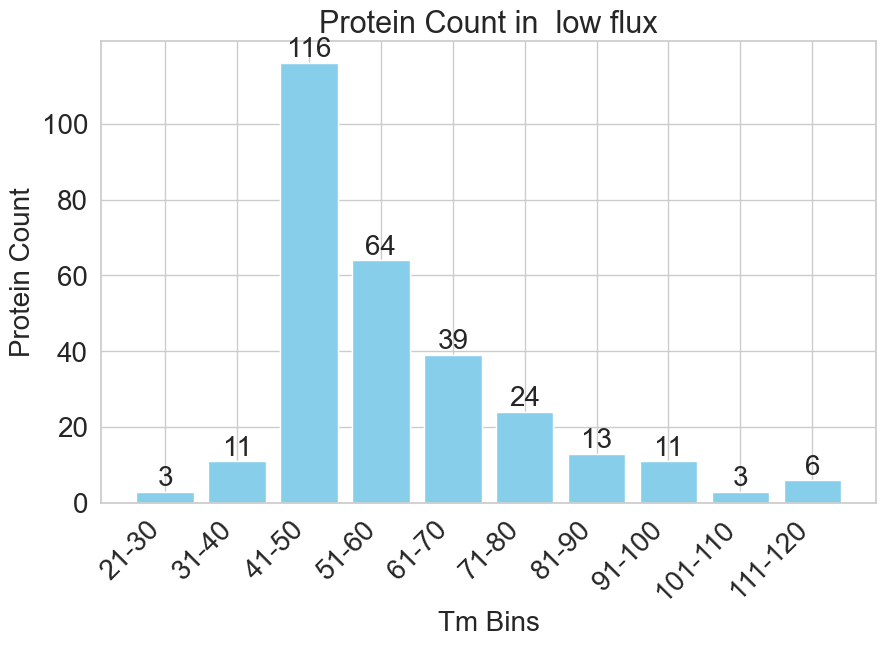

In [149]:
import math
def nearest_multiple_of_5(number):
    # 将给定数值除以5并向下取整
    nearest_multiple = math.floor(number / 10) * 10
    return nearest_multiple

# 绘制条形图
def plot_raw(data,log=False):
    plt.rc('font', size=20)  # 设置字体大小为12
    # 划分区段
    bins = range(nearest_multiple_of_5(data['Tm'].min())+1, int(data['Tm'].max()) + 6, 10)

    # 计算每个分组中的蛋白质数量
    counts, bin_edges = np.histogram(data['Tm'], bins=bins)

    # 对数量进行对数变换
    if log == True:
        counts_log = np.log10(counts)
        counts = counts_log

    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(counts)), counts, color='skyblue')
    plt.bar(range(len(counts)), counts, color='skyblue')
    plt.title('Protein Count in  low flux',fontsize=22)
    plt.xlabel('Tm Bins',fontsize=20)
    

    
    if log == True:
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{counts_log[i]:.2f}",
                 ha='center', va='bottom')
        plt.yticks(np.arange(0, np.floor(counts_log.max()) + 1, 1),fontsize=12)
        plt.ylabel('log(Protein Count)')
        plt.xticks(range(len(bins)-1), [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)], rotation=45, ha='right')
    if log == False:
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{counts[i]}",
                     ha='center', va='bottom')
        plt.yticks(np.arange(0, np.floor(counts.max()) + 1, 20),fontsize=20)
        plt.ylabel('Protein Count',fontsize=20)
        plt.xticks(range(len(bins)-1), [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)], rotation=45, ha='right',fontsize=20)
    plt.show()
plot_raw(data_filtered)

In [115]:
model = build_model()
# test_model = keras.Model()

adam = optimizers.legacy.Adam(learning_rate=0.0002)

model_path = r'train_model2/bestAcc.h53'
# model_path = r'/lustre/home/acct-bmelgn/bmelgn-2/QianWei/MIPPI2/src/kaggle/cross_validation/activation_test/s51_leaky_3block_wfl_gp_HE/bestAcc.h51'


#model_path = r'bestAcc.h54'
model.load_weights(model_path)
model.compile(adam, loss='binary_crossentropy', 
              metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2acc')])
model.summary()

pssm: (None, 512, 20)
seq: (None, 512, 44)
x: (None, 512, 64)
outputs: Tensor("cn_3/softmax/Softmax:0", shape=(None, 2), dtype=float32)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 512, 20)]            0         []                            
                                                                                                  
 cn_3 (cn)                   (None, 2)                    421534    ['input_7[0][0]',             
                                                                     'input_8[0][0]']             
                                                       

In [117]:
x_test = data_test
y_test = label

In [118]:
x_test = data_test
y_test = label
y_pred = model.predict(x_test, verbose=0)
y_true = y_test
    
model_metrics(y_test.argmax(axis=-1), y_pred.argmax(axis=-1))

y_pred, y_true = evaluate_model(model, x_test, y_test)

pssm: (None, 512, 20)
seq: (None, 512, 44)
x: (None, 512, 64)
outputs: Tensor("model_3/cn_3/softmax/Softmax:0", shape=(None, 2), dtype=float32)
conf_mat: [[143  49]
 [ 63  35]]
conf_mat: [[143  49]
 [ 63  35]]
precision	recall	f1	mcc_score	accuracy
metrics:
 [[0.69417476 0.74479167 0.71859296 0.10629472 0.6137931 ]
 [0.41666667 0.35714286 0.38461538 0.10629472 0.6137931 ]]
confusion_matrix:
 [[143  49]
 [ 63  35]]
model default metrics: 

['loss', 'acc', 'top2acc']
[0.8623883724212646, 0.6137930750846863, 1.0]
conf_mat: [[ 35  63]
 [ 49 143]]
----------------------binary_metrics-----------------------
precision	recall	f1	mcc_score	accuracy
metrics:
 [[0.41666667 0.35714286 0.38461538 0.10629472 0.6137931 ]
 [0.69417476 0.74479167 0.71859296 0.10629472 0.6137931 ]]
auc: 0.5703125
cm: 
[[ 35  63]
 [ 49 143]]


In [150]:
from sklearn.metrics import confusion_matrix

# 将预测的类别与真实的类别转换为混淆矩阵
conf_matrix = confusion_matrix(y_true.argmax(axis=-1), y_pred.argmax(axis=-1))

# 从混淆矩阵中提取TN, TP, FN, FP
TN = conf_matrix[0, 0]
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
FP = conf_matrix[0, 1]

print("True Negatives (TN):", TN)
print("True Positives (TP):", TP)
print("False Negatives (FN):", FN)
print("False Positives (FP):", FP)


True Negatives (TN): 143
True Positives (TP): 35
False Negatives (FN): 63
False Positives (FP): 49
